## 🧠 Physics-Informed Neural Network for the 3D Magnetic Induction Equation

This PINN implements the **kinematic dynamo model** studied by
**V. Archontis, S. B. F. Dorch, and Å. Nordlund (2003), _A&A 397, 393–399_**.
The governing equation is the **magnetic induction equation**:

$$
\frac{\partial \mathbf{B}}{\partial t}
= \nabla \times (\mathbf{u} \times \mathbf{B})
+ \frac{1}{Re_m} \nabla^2 \mathbf{B},
\qquad \nabla \cdot \mathbf{B} = 0
$$

where
- **$ \mathbf{B}(x,y,z,t) = (B_x,B_y,B_z) $** is the magnetic field,
- **$ \mathbf{u}(x,y,z) $** is a prescribed incompressible velocity field,
- **$ Re_m $** is the magnetic Reynolds number.

---

### ⚙️ Velocity Field
$$
\mathbf{u}_{ABC} =
\big(0,\;
u_0\sin(z/2),\;
0\big),
$$

---
### ⚙️ Magnetic Field at t = 0

$$
B = (0, 0, B_0)
$$

---
### 🧩 PINN Architecture
- **Input:** spatial–temporal coordinates $(x, y, z, t)$
- **Output:** magnetic field components $(B_x, B_y, B_z)$
- **Network:** fully connected MLP with 4 hidden layers × 64 neurons
(activation: **Tanh**)
- **Loss function:**
  1. **PDE residual loss** enforcing
  $\partial_t \mathbf{B} - \nabla\times(\mathbf{u}\times\mathbf{B}) - \frac{1}{Re_m}\nabla^2\mathbf{B} = 0$
  2. **Divergence-free loss** enforcing $\nabla\cdot\mathbf{B}=0$
  3. **Initial-condition loss** ensuring $\mathbf{B}(x,y,z,0)=\mathbf{B}_0(x,y,z)$
- **Optimizer:** Adam with StepLR scheduler (decay every 500 epochs)
- **Training points:**
  - Collocation points ($N_f$) sampled uniformly in the 4-D domain
  - Initial-condition points ($N_0$) at $t=0$
- **Domain:** $ x,y,z \in [0,2\pi] $, $t \in [0,T_{\text{max}}]$

---

### 📈 Physical Meaning
The network learns a magnetic field evolution that simultaneously:
- satisfies the **induction equation** everywhere in the domain,
- preserves **solenoidality** ($\nabla\cdot\mathbf{B}=0$),
- matches the **initial seed field** (small random perturbation).

This mimics the **kinematic dynamo regime**, where magnetic fields grow
exponentially through stretching and folding by the ABC flow,
as described in the reference paper.

---

### 📊 Visualization & Outputs
The training script plots:
- **Total loss** vs. epoch
- **Magnetic energy** ($E_m = \tfrac{1}{2}\langle|\mathbf{B}|^2\rangle$) vs. epoch
- **|B| field slice** at $ z=\pi $, $t=T_{\text{max}}$

---

### 🧾 Reference
Archontis V., Dorch S. B. F., Nordlund Å. (2003).
**"Numerical simulations of kinematic dynamo action."**

_Astronomy & Astrophysics_ [https://www.aanda.org/articles/aa/pdf/2003/02/aa2653.pdf](https://www.aanda.org/articles/aa/pdf/2003/02/aa2653.pdf)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


## PINN architecture

In [ ]:
# Neural Network for Magnetic Induction Equation (Vector B)

class PINN_Magnetic3D(nn.Module):
    def __init__(self, layers, dropout_prob=0.1):
        super(PINN_Magnetic3D, self).__init__()
        self.layers = nn.ModuleList()
        # self.dropout = nn.Dropout(p=dropout_prob)
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x, y, z, t):
        inp = torch.cat([x, y, z, t], dim=1)
        for i in range(len(self.layers) - 2):  # all hidden layers except last
            inp = self.activation(self.layers[i](inp))
            # inp = self.dropout(inp)  # apply dropout after activation
        out = self.layers[-1](inp)
        return out  # (N, 3)


def to_tensor(x, requires_grad=True):
    return torch.as_tensor(x, dtype=torch.float32, device=device)



## PDE residual definitions

In [ ]:
# -------------------------
# Differential helpers
# -------------------------
def gradient(f, x):
    # returns df/dx with same shape as f
    return torch.autograd.grad(f, x, torch.ones_like(f), retain_graph=True, create_graph=True)[0]

def laplacian_scalar(f, x, y, z):
    # compute d^2 f / dx^2 + d^2 f / dy^2 + d^2 f / dz^2
    f_x = gradient(f, x)
    f_xx = gradient(f_x, x)
    f_y = gradient(f, y)
    f_yy = gradient(f_y, y)
    f_z = gradient(f, z)
    f_zz = gradient(f_z, z)
    return f_xx + f_yy + f_zz

def curl_from_components(vx, vy, vz, x, y, z):
    # curl = (dvz/dy - dvy/dz, dvx/dz - dvz/dx, dvy/dx - dvx/dy)
    vz_y = gradient(vz, y)
    vy_z = gradient(vy, z)
    vx_z = gradient(vx, z)
    vz_x = gradient(vz, x)
    vy_x = gradient(vy, x)
    vx_y = gradient(vx, y)
    curl_x = vz_y - vy_z
    curl_y = vx_z - vz_x
    curl_z = vy_x - vx_y
    return curl_x, curl_y, curl_z

# -------------------------
# PDE residual for induction eq
# -------------------------
def pde_residual(model, u_func, x, y, z, t, u0):
    # ensure grads
    x.requires_grad_(True); y.requires_grad_(True); z.requires_grad_(True); t.requires_grad_(True)

    B = model(x, y, z, t)         # (N,3)
    Bx = B[:, 0:1]; By = B[:, 1:2]; Bz = B[:, 2:3]

    # time derivatives
    Bx_t = gradient(Bx, t)
    By_t = gradient(By, t)
    Bz_t = gradient(Bz, t)

    # velocity
    ux, uy, uz = u_func(x, y, z, u0)

    # u × B
    uxB_x = uy * Bz - uz * By
    uxB_y = uz * Bx - ux * Bz
    uxB_z = ux * By - uy * Bx

    # curl(u × B)
    curl_x, curl_y, curl_z = curl_from_components(uxB_x, uxB_y, uxB_z, x, y, z)

    # laplacian(B)
    lapBx = laplacian_scalar(Bx, x, y, z)
    lapBy = laplacian_scalar(By, x, y, z)
    lapBz = laplacian_scalar(Bz, x, y, z)

    # residuals
    fBx = Bx_t - curl_x
    fBy = By_t - curl_y
    fBz = Bz_t - curl_z

    # divergence free
    divBx = gradient(Bx, x)
    divBy = gradient(By, y)
    divBz = gradient(Bz, z)
    divB = divBx + divBy + divBz

    return fBx, fBy, fBz, divB



In [ ]:
# -------------------------
# Velocity Field (u = u0 sin(z/2) ŷ)
# -------------------------
def velocity_field(x, y, z, u0):
    ux = torch.zeros_like(x)
    uy = u0 * torch.sin(z / 2)
    uz = torch.zeros_like(x)
    return ux, uy, uz

## Domain and initial/boundary conditions


In [ ]:
# -------------------------
# Problem hyperparams
# -------------------------
u0 = 1.0
B0 = 1.0

domain_min = -1
domain_max = 1
T_max = 5.0

N_f = 2500
N0  = 500
lr = 1e-3

# -------------------------
# Initial condition: B = (0, 0, B0)
# -------------------------
def initial_B(x, y, z, B0):
    return np.tile([0, 0, B0], (len(y), 1))



# -------------------------
# Dataset (random collocation inside domain)
# -------------------------
def sample_domain(N, t_min=0.0, t_max=T_max):
    x = np.random.uniform(domain_min, domain_max, (N,1))
    y = np.random.uniform(domain_min, domain_max, (N,1))
    z = np.random.uniform(domain_min, domain_max, (N,1))
    t = np.random.uniform(t_min, t_max, (N,1))
    return x, y, z, t


# initial IC points
x0_np, y0_np, z0_np = (np.random.uniform(domain_min, domain_max, (N0,1)) for _ in range(3))
t0_np = np.zeros((N0,1))
B0_np = initial_B(x0_np, y0_np, z0_np, B0)

# convert to tensors
x0_t = to_tensor(x0_np); y0_t = to_tensor(y0_np); z0_t = to_tensor(z0_np); t0_t = to_tensor(t0_np)
B0_t = to_tensor(B0_np)


[    0] loss: 1.296e+00  loss_pde:3.160e-02 loss_div:6.130e-02 loss_ic:3.671e-01 lr: 1.000e-03
[  250] loss: 1.113e-02  loss_pde:7.950e-04 loss_div:1.241e-04 loss_ic:1.942e-03 lr: 1.000e-03
[  500] loss: 1.999e-03  loss_pde:1.213e-04 loss_div:3.107e-05 loss_ic:4.754e-04 lr: 5.000e-04
[  750] loss: 1.287e-03  loss_pde:6.788e-05 loss_div:1.776e-05 loss_ic:4.302e-04 lr: 5.000e-04
[ 1000] loss: 9.023e-04  loss_pde:4.127e-05 loss_div:1.073e-05 loss_ic:3.823e-04 lr: 2.500e-04
[ 1250] loss: 8.023e-04  loss_pde:3.538e-05 loss_div:9.237e-06 loss_ic:3.561e-04 lr: 2.500e-04
[ 1500] loss: 7.216e-04  loss_pde:3.132e-05 loss_div:8.014e-06 loss_ic:3.283e-04 lr: 1.250e-04
[ 1750] loss: 6.532e-04  loss_pde:2.699e-05 loss_div:7.025e-06 loss_ic:3.130e-04 lr: 1.250e-04
[ 2000] loss: 6.180e-04  loss_pde:2.578e-05 loss_div:6.272e-06 loss_ic:2.974e-04 lr: 6.250e-05
[ 2250] loss: 5.943e-04  loss_pde:2.396e-05 loss_div:6.611e-06 loss_ic:2.885e-04 lr: 6.250e-05
[ 2500] loss: 5.525e-04  loss_pde:2.178e-05 loss_d

## Training loop with Adam optimizer

In [ ]:

model = PINN_Magnetic3D([4, 64, 64, 64, 3]).to(device)
# model = PINN_Magnetic3D([4, 64, 64, 64, 3], dropout_prob=0.05).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

loss_history = []
mag_energy_history = []
epochs = 10000  # training epochs


for ep in range(epochs):
    model.train()
    optimizer.zero_grad()
    # sample collocation points each epoch (physics-informed collocation)
    x_f_np, y_f_np, z_f_np, t_f_np = sample_domain(N_f)
    x_f = to_tensor(x_f_np, requires_grad=True)
    y_f = to_tensor(y_f_np, requires_grad=True)
    z_f = to_tensor(z_f_np, requires_grad=True)
    t_f = to_tensor(t_f_np, requires_grad=True)

    fBx, fBy, fBz, divB = pde_residual(model, velocity_field, x_f, y_f, z_f, t_f, u0)
    loss_pde = torch.mean(fBx**2 + fBy**2 + fBz**2)
    # loss_pde = torch.mean(torch.sqrt(fBx**2 + fBy**2 + fBz**2))

    loss_div = torch.mean(divB**2)

    B0_pred = model(x0_t, y0_t, z0_t, t0_t)
    loss_ic = torch.mean((B0_pred - B0_t)**2)

    loss = 10.0*loss_pde + 10.0*loss_div + 1.0*loss_ic  # weights can be tuned
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())

    if ep % 250 == 0:
        print(f"[{ep:5d}] loss: {loss.item():.3e}  loss_pde:{loss_pde.item():.3e} loss_div:{loss_div.item():.3e} loss_ic:{loss_ic.item():.3e} lr: {scheduler.get_last_lr()[0]:.3e}")

In [ ]:
# path = "/content/drive/MyDrive/NN_Models"
# m_name = "/2D_kinematic_dynamo_action_10k_tanh_x,y,z"
# torch.save(model, path + m_name + ".pt")

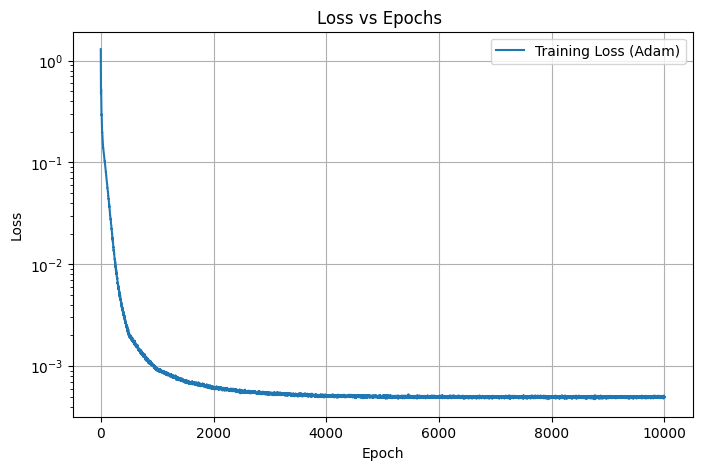

In [ ]:
# -----------------------------
# Plot loss
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(loss_history, label="Training Loss (Adam)")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs ")
plt.legend()
plt.grid(True)
# plt.savefig(path + m_name + "_Loss.png")  # Save the plot as a PNG file
plt.show()

## Plot model vs. actual field at t = 0

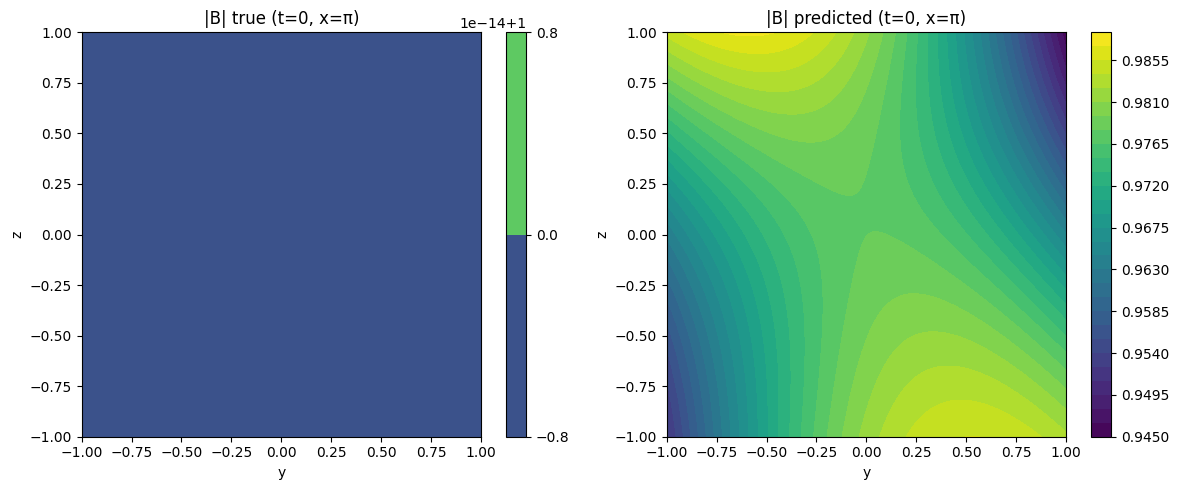

In [ ]:
model.eval()
with torch.no_grad():
    Nx, Ny, Nz = 100, 100, 100  # grid resolution
    x_grid = np.linspace(domain_min, domain_max, Nx)
    y_grid = np.linspace(domain_min, domain_max, Ny)
    z_grid = np.linspace(domain_min, domain_max, Nz)
    X, Y, Z = np.meshgrid(x_grid, y_grid, z_grid, indexing='ij')

    # Prepare tensors
    x_t = to_tensor(X.flatten()[:, None])
    y_t = to_tensor(Y.flatten()[:, None])
    z_t = to_tensor(Z.flatten()[:, None])
    t_t = torch.zeros_like(x_t)

    # Model prediction
    B_pred = model(x_t, y_t, z_t, t_t).cpu().numpy()
    Bx_pred, By_pred, Bz_pred = B_pred[:, 0], B_pred[:, 1], B_pred[:, 2]

    # Compute |B| and reshape
    Bmag_pred = np.sqrt(Bx_pred**2 + By_pred**2 + Bz_pred**2).reshape(Nx, Ny, Nz)

    # Choose a slice (x = π plane)
    x_index = np.argmin(np.abs(x_grid - np.pi))
    Bmag_pred_slice = Bmag_pred[x_index, :, :]

    # True (analytical) field
    By_true = np.zeros((Ny, Nz))
    Bz_true = np.ones((Ny, Nz)) * B0
    Bmag_true = np.sqrt(By_true**2 + Bz_true**2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cs1 = axes[0].contourf(y_grid, z_grid, Bmag_true.T, levels=30)
axes[0].set_title("|B| true (t=0, x=π)")
axes[0].set_xlabel("y")
axes[0].set_ylabel("z")
fig.colorbar(cs1, ax=axes[0])

cs2 = axes[1].contourf(y_grid, z_grid, Bmag_pred_slice.T, levels=30)
axes[1].set_title("|B| predicted (t=0, x=π)")
axes[1].set_xlabel("y")
axes[1].set_ylabel("z")
fig.colorbar(cs2, ax=axes[1])

plt.tight_layout()
plt.show()


## 2x2 Subplot: Model vs True Field Components


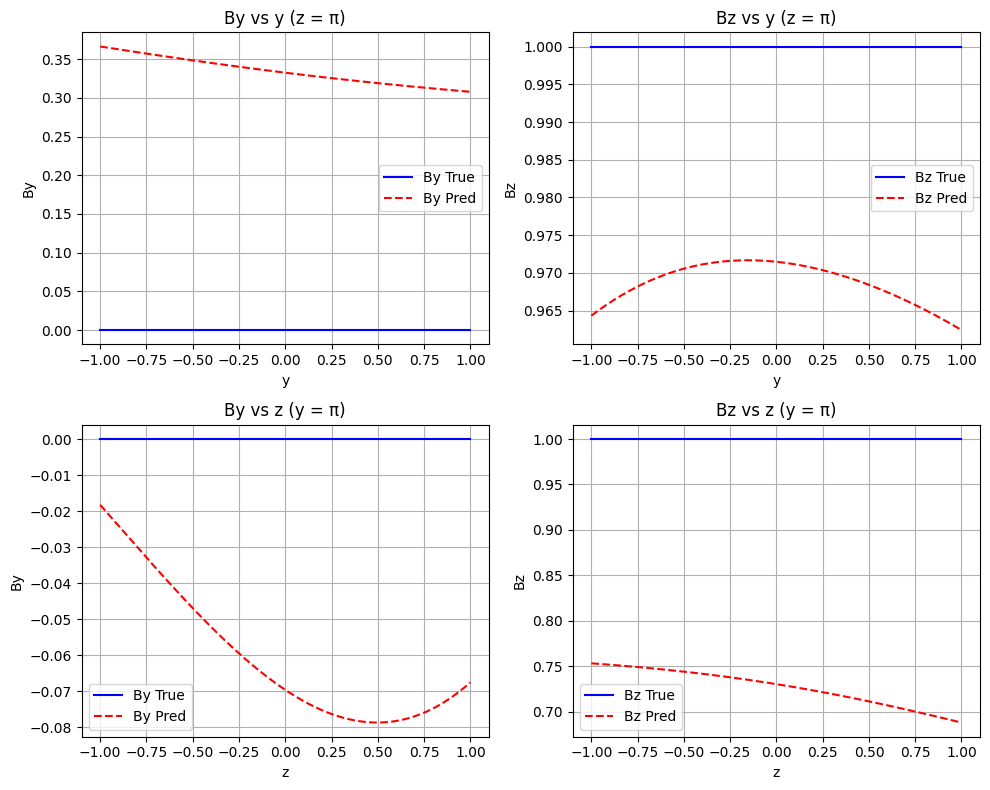

In [ ]:
x_fixed = 0 * np.ones(200)  # fix x = 0 plane
y_line = np.linspace(domain_min, domain_max, 200)
z_line = np.linspace(domain_min, domain_max, 200)

# Prepare data for Bz vs y and By vs y  (fix z = π)
z_fixed = np.pi * np.ones_like(y_line)
x_t = to_tensor(x_fixed[:, None])
y_t = to_tensor(y_line[:, None])
z_t = to_tensor(z_fixed[:, None])
t_t = torch.zeros_like(y_t)

# Model prediction
with torch.no_grad():
    B_pred_y = model(x_t, y_t, z_t, t_t).detach().cpu().numpy()

Bx_pred_y, By_pred_y, Bz_pred_y = B_pred_y[:, 0], B_pred_y[:, 1], B_pred_y[:, 2]

# True fields (example assumption)
By_true_y = np.zeros_like(y_line)
Bz_true_y = np.ones_like(y_line) * B0

# Prepare data for Bz vs z and By vs z  (fix y = π)
y_fixed = np.pi * np.ones_like(z_line)
x_t = to_tensor(np.pi * np.ones_like(z_line)[:, None])
y_t = to_tensor(y_fixed[:, None])
z_t = to_tensor(z_line[:, None])
t_t = torch.zeros_like(z_t)

with torch.no_grad():
    B_pred_z = model(x_t, y_t, z_t, t_t).detach().cpu().numpy()

Bx_pred_z, By_pred_z, Bz_pred_z = B_pred_z[:, 0], B_pred_z[:, 1], B_pred_z[:, 2]

# True fields (example assumption)
By_true_z = np.zeros_like(z_line)
Bz_true_z = np.ones_like(z_line) * B0

# -------------------------
# Plot 2×2 grid
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Top-left → By vs y
axes[0, 0].plot(y_line, By_true_y, 'b-', label='By True')
axes[0, 0].plot(y_line, By_pred_y, 'r--', label='By Pred')
axes[0, 0].set_xlabel("y"); axes[0, 0].set_ylabel("By")
axes[0, 0].set_title("By vs y (z = π)")
axes[0, 0].legend(); axes[0, 0].grid(True)

# Top-right → Bz vs y
axes[0, 1].plot(y_line, Bz_true_y, 'b-', label='Bz True')
axes[0, 1].plot(y_line, Bz_pred_y, 'r--', label='Bz Pred')
axes[0, 1].set_xlabel("y"); axes[0, 1].set_ylabel("Bz")
axes[0, 1].set_title("Bz vs y (z = π)")
axes[0, 1].legend(); axes[0, 1].grid(True)

# Bottom-left → By vs z
axes[1, 0].plot(z_line, By_true_z, 'b-', label='By True')
axes[1, 0].plot(z_line, By_pred_z, 'r--', label='By Pred')
axes[1, 0].set_xlabel("z"); axes[1, 0].set_ylabel("By")
axes[1, 0].set_title("By vs z (y = π)")
axes[1, 0].legend(); axes[1, 0].grid(True)

# Bottom-right → Bz vs z
axes[1, 1].plot(z_line, Bz_true_z, 'b-', label='Bz True')
axes[1, 1].plot(z_line, Bz_pred_z, 'r--', label='Bz Pred')
axes[1, 1].set_xlabel("z"); axes[1, 1].set_ylabel("Bz")
axes[1, 1].set_title("Bz vs z (y = π)")
axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


## Visualize B magnitude slice at final time T_max, z=pi


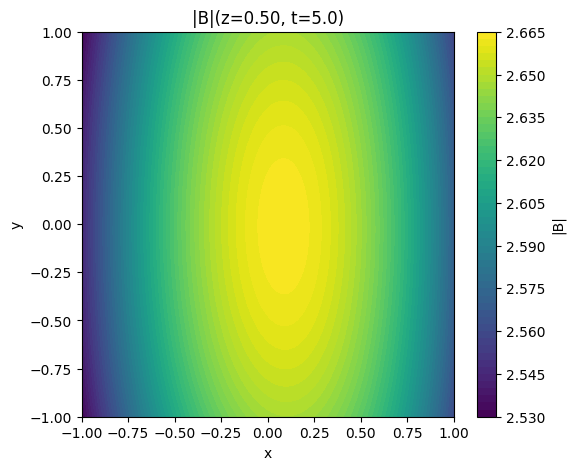

In [ ]:
with torch.no_grad():
    Nx = 120
    xs = np.linspace(domain_min, domain_max, Nx)
    ys = np.linspace(domain_min, domain_max, Nx)
    X, Y = np.meshgrid(xs, ys)
    Z = np.full_like(X, domain_max/2.0)
    Tt = np.full_like(X, T_max)
    xt = to_tensor(X.flatten()[:,None]); yt = to_tensor(Y.flatten()[:,None])
    zt = to_tensor(Z.flatten()[:,None]); tt = to_tensor(Tt.flatten()[:,None])
    Bf = model(xt, yt, zt, tt).cpu().numpy()
    Bmag = np.sqrt(np.sum(Bf**2, axis=1)).reshape(Nx,Nx)

plt.figure(figsize=(6,5))
plt.contourf(X, Y, Bmag, levels=60)
plt.colorbar(label='|B|')
plt.title(f'|B|(z={domain_max/2.0:.2f}, t={T_max})')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

## Plot Emag vs Time (Post-training analysis)



Calculating magnetic energy evolution over time...


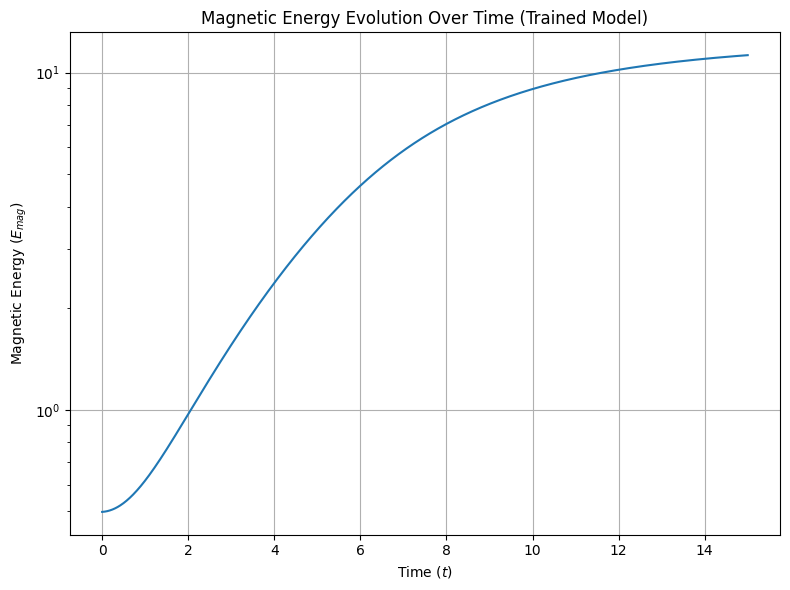

In [ ]:
print("\nCalculating magnetic energy evolution over time...")

# Set the model to evaluation mode
model.eval()

# Define the grid for calculating the volume-averaged energy
N_grid = 32 # Spatial resolution for the grid (32x32x32). Lower for faster computation.
x_dom = np.linspace(domain_min, domain_max, N_grid)
y_dom = np.linspace(domain_min, domain_max, N_grid)
z_dom = np.linspace(domain_min, domain_max, N_grid)
X, Y, Z = np.meshgrid(x_dom, y_dom, z_dom)

# Flatten and convert the spatial grid to tensors once
x_vol = to_tensor(X.flatten()[:, None])
y_vol = to_tensor(Y.flatten()[:, None])
z_vol = to_tensor(Z.flatten()[:, None])

# Define time steps for the plot
t_steps = 1000
t_plot = np.linspace(0, T_max + 10, t_steps)
emag_vs_time = []

with torch.no_grad():
    for t_val in t_plot:
        # Create a time tensor for the current time step
        t_vol = to_tensor(np.full_like(X.flatten()[:, None], t_val))

        # Predict the magnetic field B at this time step over the entire volume
        B_pred = model(x_vol, y_vol, z_vol, t_vol).cpu().numpy()

        # Calculate the mean magnetic energy for this time step
        # Emag = 0.5 * <B^2> integrated over volume
        emag_current = 0.5 * np.mean(np.sum(B_pred**2, axis=1))
        emag_vs_time.append(emag_current)

        # Optional: print progress
        if len(emag_vs_time) % 10 == 0:
            # print(f"  Computed for t = {t_val:.2f}, Emag = {emag_current:.4e}")
            pass

# Create the plot
plt.figure(figsize=(8, 6))
# emag_vs_time = np.log(emag_vs_time)
plt.plot(t_plot, emag_vs_time)#, marker='o', markersize=4, linestyle='-')
plt.yscale('log')  # Dynamo action is exponential
plt.xlabel("Time ($t$)")
plt.ylabel("Magnetic Energy ($E_{mag}$)")
plt.title("Magnetic Energy Evolution Over Time (Trained Model)")
plt.grid(True)
plt.tight_layout()
plt.savefig(path + m_name + "_EvsT_Plot.png")  # Save the plot as a PNG file
plt.show()

In [ ]:
# 1A: Check B magnitude distribution at t=0 and later
model.eval()
with torch.no_grad():
    # pick a small set of random points
    idx = np.random.choice(x_vol.shape[0], size=1000, replace=False)
    pts_x = x_vol[idx]; pts_y = y_vol[idx]; pts_z = z_vol[idx]
    t0 = to_tensor(np.zeros((len(idx),1)))
    tlate = to_tensor(np.full((len(idx),1), T_max))

    B0 = model(pts_x, pts_y, pts_z, t0).cpu().numpy()   # shape (N,3)
    Blate = model(pts_x, pts_y, pts_z, tlate).cpu().numpy()

print("B0 min/max, mean |B|:", np.min(np.linalg.norm(B0,axis=1)),
      np.max(np.linalg.norm(B0,axis=1)), np.mean(np.linalg.norm(B0,axis=1)))
print("B(T) min/max, mean |B|:", np.min(np.linalg.norm(Blate,axis=1)),
      np.max(np.linalg.norm(Blate,axis=1)), np.mean(np.linalg.norm(Blate,axis=1)))


B0 min/max, mean |B|: 0.95147336 1.0280057 0.99693084
B(T) min/max, mean |B|: 2.452466 2.7006087 2.6148345


## Evolution of |B| at a single point over time



bvals min/max: 1.0152782 4.7775536 ratio max/min: 4.7056594


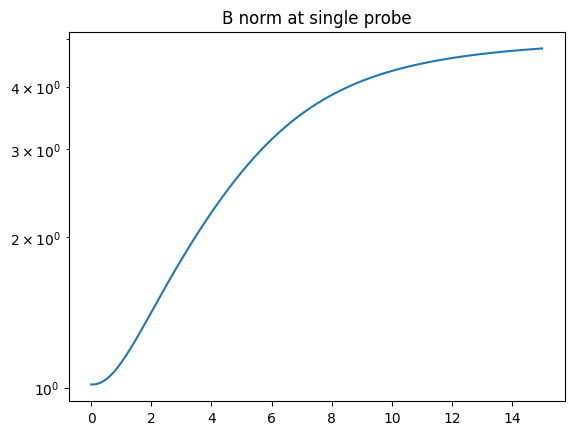

In [ ]:
x, y, z = 0,0,0
# x, y, z = np.pi, np.pi, np.pi
# x, y, z = np.pi/4, np.pi/3, np.pi/6
# x, y, z = 2*np.pi, 2*np.pi, 2*np.pi
xp = to_tensor(np.array([[x]]))
yp = to_tensor(np.array([[y]]))
zp = to_tensor(np.array([[z]]))
bvals = []
for tval in t_plot:
    tb = to_tensor(np.array([[tval]]))
    with torch.no_grad():
        b = model(xp,yp,zp,tb).cpu().numpy().ravel()
    bvals.append(np.linalg.norm(b))
bvals = np.array(bvals)
print("bvals min/max:", bvals.min(), bvals.max(), "ratio max/min:", bvals.max()/max(bvals.min(),1e-30))
plt.semilogy(t_plot, bvals); plt.title("B norm at single probe"); plt.show()
